In [727]:
# 全局变量 (不会刷新)
DCMRealTrajectory_list = []
CoMTrajectory_list = []
CoPTrajectory_list = []
parameters_list = []

In [773]:
#In the following we import the classes that we need for simulation
import time
import pybullet as p#pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from FootTrajectoryRecovery import * # Foot trajectory generation Class
from RobotUtils import * # Class related to Inverse Kinematics 

from qpsolvers import solve_qp
from scipy.spatial.transform import Rotation as R #To calculate rotation matrix

In [774]:
# p.disconnect()

<div style="text-align:center"><span style="color:purple; font-family:helvetica; font-size:2.0em;">Bipedal Locomotion Control based on Divergent Component of Motion(DCM)</span></div>

<div style="text-align:center"><span style="font-family:helvetica; font-size:2.37em;">Second Part: Push Recovery During Walking </span></div>

<div style="text-align:center"><span style="font-family:helvetica; font-size:1.7em;">Preparing Pybullet environment 开启GUI + 载入机器人与环境</span></div>

In [775]:
###################################################################################################
#In the following we create an object of dynamic engine of pybullet and we connect it to the Pybullet GUI
phisycsClient = p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

###################################################################################################
#In the following we load the urdf model of the robot and we specify the setting for the simulation
p.resetSimulation()
planeID = p.loadURDF("plane.urdf")
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)
p.setGravity(0,0,-9.81)
p.configureDebugVisualizer(p.COV_ENABLE_RGB_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_DEPTH_BUFFER_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_SEGMENTATION_MARK_PREVIEW,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_RENDER_CONTROLLERS,0)
p.configureDebugVisualizer(p.COV_ENABLE_Y_AXIS_UP,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_PICKING,0)
p.configureDebugVisualizer(p.COV_ENABLE_VR_TELEPORTING,0)
p.configureDebugVisualizer(p.COV_ENABLE_WIREFRAME,0)
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0) 
p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
atlas = robotID = p.loadURDF("atlas/atlas_v4_with_multisense.urdf", [0,0,0.93],useFixedBase = 0)
p.setPhysicsEngineParameter()
p.setRealTimeSimulation(0)

# 设置相机位置
cameraDistance = 2  # 距离目标物体的距离
# cameraYaw = -90 #50  # 从目标的水平角度
cameraYaw = 50  # 从目标的水平角度
cameraPitch = -30  # 从目标的垂直角度
cameraTargetPosition = [0, 0, 0.93]  # 相机对准的目标位置（通常是机器人的位置）
p.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, cameraTargetPosition) # 设置相机

<div style="text-align:center"><span style="font-family:helvetica; font-size:1.7em;">Initialization of the Robot 不用修改</span></div>


In [776]:
AtlasUtils = RobotUtils()#This object is responsible for inverse kinematics
CoMHeight=0.63 #Constant pelvis(CoM) height
stepWidth=0.3#=lateralDistanceOfFeet/2
stepLength=0.57 #longitudinal distance between two sequential feet stepLength=stepStride/2, 
stepDuration = 0.43
dt=1.0/240.0

#Preparing the constant joints position for the upper-body joints
bodyPositions = [0.0,0.0,0.0,0.0]
leftArmIndex = [3,4,5,6,7,8,9]
rightArmIndex= [11,12,13,14,15,16,17]
bodyIndex = [0,1,2,10]
leftLegIndex=[18,19,20,21,22,23]
rightLegIndex=[24,25,26,27,28,29]
jointsIndex= np.zeros(30)
jointsPositions= np.zeros(30)
jointsIndex[0:4]=bodyIndex
jointsIndex[4:11]=rightArmIndex
jointsIndex[11:18]=leftArmIndex
jointsIndex[18:24]=rightLegIndex
jointsIndex[24:30]=leftLegIndex
jointsPositions[0:4]=bodyPositions

#00FF00 慢走调参
NominalStepWidth  = 0.15  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.1  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.2 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.3




#00FF00 中走调参
NominalStepWidth  = 0.1  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.3  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.4 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.4





#00FF00 中走调参
NominalStepWidth  = 0.1  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.5  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.4 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.4





#00FF00 快走调参
NominalStepWidth  = 0.1  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.6  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.25 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.5




#00FF00 快走调参
NominalStepWidth  = 0.1  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.6  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.24 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.5





#00FF00 快走调参
NominalStepWidth  = 0.1  # Nominal lateralDistanceOfFeet/2                                          #00FF00 原先为 0.1
NominalStepLength = 0.7  # Nominal longitudinal distance between two sequential feet                #00FF00 原先为 0.5
NominalStepDuration = 0.3 #TODO tune Nominal step duration to find a value that push reovery works  #00FF00 原先为 0.4   行走速度变化，越小迈步时间越短

#00FF00 变更约束条件
GAP = 0.4




# 记录 NominalStepDuration
Ntime = NominalStepDuration


stepWidth = NominalStepWidth
stepLength = NominalStepLength 
stepDuration = NominalStepDuration


for i in range(int(3/dt)):  #1000 sampling time will be allocated for the initialization of the robot position
    #Solving the inverse kinematic and sending the joints position command to the robot
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,0.9 - (i*dt/3)* (0.9-CoMHeight)], np.eye(3),[0.0,stepWidth,0.0], np.eye(3),[0.0, -stepWidth,0.0], np.eye(3))
    jointsPositions[24:30] =lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)

    p.stepSimulation()
    time.sleep(0.0002)
for i in range(20):  #just keep robot at constant CoM height for a few timestep
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,CoMHeight], np.eye(3),[0.0,stepWidth,0.0], np.eye(3),[0.0, -stepWidth,0.0], np.eye(3))
    jointsPositions[24:30] =lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    
    p.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex.astype(int),
                                controlMode=p.POSITION_CONTROL,
                                targetPositions = jointsPositions)

    p.stepSimulation()
    time.sleep(0.0002)

<div style="text-align:center"><span style="font-family:helvetica; font-size:1.7em;">Initialization of Parameters 不用修改</span></div>


In [777]:
DCMGenerator = DCMTrajectoryGenerator(CoMHeight)             #TODO: We create an object of DCMTrajectoryGenerator Class 创建 Class 类的对象
# Finding offset based on nominal time duration, Nominal step length and nominalstep width. The idea is that we expect the DCM to have the same offset from the next nominal step location
offsety = 2 * NominalStepWidth / (np.exp(DCMGenerator.omega * NominalStepDuration)+1)  
offsetx = 2 * NominalStepLength / (np.exp(DCMGenerator.omega * NominalStepDuration)+1)

# Set initial values for the optimization probelm
AtlasUtils = RobotUtils()
CoMPoS, robotOrn =  p.getBasePositionAndOrientation(robotID) #TODO: receive the base position and orientation (use pybullet documentation for finding the related function) 
CoMVel,_ = p.getBaseVelocity(robotID)                        #TODO: receive the base velocity 
DCM0 =  CoMPoS + np.asarray(CoMVel)/DCMGenerator.omega       #TODO: set DCM position based on CoM position and CoM velocity (assume CoM is on the center of base (pelvis)
CoM0 = np.asarray(CoMPoS)

CoPX=p.getLinkState(robotID,29)[0][0] #initial CoP position in y direction (Right foot position specifies first CoP)
CoPY=p.getLinkState(robotID,29)[0][1] #initial CoP position in y direction 

#FFFFFF 录像功能
#uncomment for saving video, there is another line that you also need to uncomment at the end of the code)
# curr_recording = p.startStateLogging(p.STATE_LOGGING_VIDEO_MP4,"Record" + "/Walking"+ ".mp4") 

maximumFootHeight = 0.2

#create some lists for collecting data and plotting
DCMTrajectory = list("")
DCMRealTrajectory = list("")
CoMTrajectory = list("")
CoMRealTrajectory = list("")
CoPTrajectory = list("")
ControlInputs = list("")
rightFootTraj_x = list("")
rightFootTraj_y = list("")
leftFootTraj_x = list("")
leftFootTraj_y = list("")
Ux_planned = list("")
Uy_planned = list('')

#FFFFFF 添加用于观察 两个变量的变化
stepDuration_list = list("") 
dt_list           = list("") 

#Initialize DCM Generator
DCMGenerator.initialDCM = np.array([DCM0[0] + 0.1 ,DCM0[1]]) #initial DCM position in x direction + some offset to initiate the motion
DCMGenerator.timeStep = dt
DCMGenerator.CoM = np.array([CoM0[0] ,CoM0[1]])

leftFootStartPosition = np.empty((1, 3))
leftFootStartPosition[0][:]=[0*NominalStepLength,NominalStepWidth,-0.001]
leftFootFinalPosition = np.empty((1, 3))
rightFootStartPosition = np.empty((1, 3))
rightFootStartPosition[0][:]=[0*NominalStepLength,-NominalStepWidth,-0.001]
rightFootFinalPosition = np.empty((1, 3))
leftFootStartOrientation = np.eye(3)
rightFootStartOrientation = np.eye(3)

stepNumber = 0
sign=1 #for switching between right and left leg, could +1 for left foot in swing and or -1 if right foot is in swing
internalStep = 0.0

deltaStepDurationMin= 0.3 # we substract this value from nominal step duration to find lower boundry of step duration constraint
deltaStepDurationMax= 1.3 # we add this value to nominal step duration to find upper boundry of step duration constraint
NominalStepDuration_prev = NominalStepDuration
time.sleep(1)

<div style="text-align:center"><span style="font-family:helvetica; font-size:1.7em;">Main Control Loop 需要修改</span></div>


<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;"Locomotion Planning based on DCM</span></div>

In [778]:

iter = 0
box_exists = False
while True:
   iter += 1
   
   ############################# Camera Following ####################################
   #FFFFFF Add Camera Following
   robotPos, robotOrn = p.getBasePositionAndOrientation(robotID)

   # 获取机器人朝向（四元数转换为欧拉角）
   robotOrnEuler = p.getEulerFromQuaternion(robotOrn)

   # 相机相对于机器人的位移向量（假设相机相对于机器人固定在后方，稍高一点的位置）
   relative_camera_position = [0, -cameraDistance, 0.5]  # z 轴稍微提高相机视角

   # 使用机器人方向旋转相机位置，使其相对机器人参考系移动
   rotation_matrix = np.array(p.getMatrixFromQuaternion(robotOrn)).reshape(3, 3)
   camera_offset = np.dot(rotation_matrix, relative_camera_position)

   # 计算相机的绝对位置
   camera_position = np.array(robotPos) + camera_offset

   # 重新设置相机，目标始终对准机器人
   p.resetDebugVisualizerCamera(cameraDistance, cameraYaw, cameraPitch, robotPos)
   ####################################################################################

   if iter  > 1/dt and iter  < 1/dt + 23:
      #第一步时间附近施加推力
      #applying push at the certain period of simulation
      if box_exists == False:
         #add box to apply push on the robot
         gemId = p.loadURDF("boston_box.urdf", [realCoM[0] - 0.78, -0.0, 1.7],  p.getQuaternionFromEuler([0, 0, 0]))
         gemId2 = p.loadURDF("boston_box.urdf", [realCoM[0] - 0.38, -0.3, 1.4],  p.getQuaternionFromEuler([0, 0, 0]))
         box_exists = True
          
      gemPos, gemOrn = p.getBasePositionAndOrientation(gemId)
      force = np.array([873 ,0 ,0])
      p.applyExternalForce(objectUniqueId=gemId, linkIndex=-1,forceObj=force, posObj=gemPos, flags=p.WORLD_FRAME)
      gemPos2, gemOrn2 = p.getBasePositionAndOrientation(gemId2)
      force2 = np.array([0 ,1403 ,0])
      p.applyExternalForce(objectUniqueId=gemId2, linkIndex=-1,forceObj=force2, posObj=gemPos2, flags=p.WORLD_FRAME)

   DesiredDCM   = DCMGenerator.getDCMTrajectory(dt)                            #TODO: get the desired DCM for the next time-step ✔ 
   DesiredCoM   = DCMGenerator.getCoM()                                        #TODO: get the desired CoM for the next time-step ✔
   DesiredCoM3d = np.append(DesiredCoM - CoM0[:2] , DCMGenerator.CoMHeight)    #make a 3d vector of com position by appending the com height
   realCoM,_    = p.getBasePositionAndOrientation(robotID)                     #TODO: receive the base position and orientation (use pybullet documentation for finding the related function) 
   CoMVel,_     = p.getBaseVelocity(robotID)                                   #TODO: receive the base velocity ✔
   realDCM      = np.array(realCoM) + np.array(CoMVel) /DCMGenerator.omega     #TODO: calculate real dcm of the robot  ξ = x + x'/ω = x + v/ω ✔

   # 实际值与设定值的误差
   # We consider for activating push recovery to avoid flunctuation and If DCM error is less than a threshold we will use desired DCM value
   if np.linalg.norm(DesiredDCM - realDCM[:2]) < 0.2:
      currentDCM = DesiredDCM
   else:
      currentDCM = realDCM[:2]

   DCMRealTrajectory.append(currentDCM)
   DCMGenerator.initialDCM = np.array([currentDCM[0],currentDCM[1]]) # Re-initializing the DCM generator with the current values. 

   NominalStepDuration = max(0,NominalStepDuration_prev - internalStep * dt) # Nominal step duration is shrinking  as swing foot is going forward until it touches the ground

   alphaCoPX = 1.0
   alphaCoPY = 1.0
   alphaSigma = 1.0
   alphaOffsetX = 1000
   alphaOffsetY = 1000
   
   #CoP Nominal
   CoPNoMX = NominalStepLength + CoPX           # CoPX is added here to add previous step position to the nominal step length
   CoPNoMY = 2 * sign*NominalStepWidth + CoPY   # sign parameters switches between right and left foot

   OffsetNoMX = offsetx # + 0.05 * (currentDCM[0] - CoPX)#nominal DCM x offset
   OffsetNoMY = -1*sign* offsety # nominal DCM  y offset

   duration_max = NominalStepDuration + deltaStepDurationMax
   duration_min = max(0,NominalStepDuration - deltaStepDurationMin)
   SigmaNoM =  np.exp(DCMGenerator.omega * NominalStepDuration) #TODO: #nominal sigma (function of NominalStepDuration) 用于控制迈步时长

   #make a boundry limit for the next step position and duration 
   #TODO: #00FF00
   # GAP = 1.0
   # GAP = 0.4
   # GAP = 0.3
   
   # 迈步最大距离
   CoPTMaxX = CoPNoMX+GAP  #TODO next step position maximum constraits for x, add a value and tune it to have simulation working 最大迈步X
   CoPTMaxY = CoPNoMY+GAP  #TODO next step position maximum constraits for y, add a value and tune it to have simulation working 最大迈步Y
   
   # 迈步最小距离
   CoPTMinX = CoPNoMX-GAP  #TODO next step position minimum constrait for x, add a value and tune it to have simulation working 最小迈步X
   CoPTMinY = CoPNoMY-GAP  #TODO next step position minimum constrait for y, add a value and tune it to have simulation working 最小迈步Y
   
   #0000FF 迈步时长范围 测试
   SigmaMin = np.exp(DCMGenerator.omega * (duration_min))                                  #TODO: ✔ use NominalStepDuration and deltaStepDurationMin 最小迈步时长
   SigmaMax = np.exp(DCMGenerator.omega * (duration_max))                                  #TODO: ✔ use NominalStepDuration and deltaStepDurationMax 最大迈步时长

   DCMGenerator.CoP = np.array([CoPX ,CoPY]) #update the initial CoP position in the DCMTrajectoryGenerator
   

   # TODO: use equation 14 and 16 to find the P and Q 
   #0000FF 代价函数 #0000FF
   P = np.array([[2*alphaCoPX,0,0,0,0],
                 [0,2*alphaCoPY,0,0,0],
                 [0,0,2*alphaSigma,0,0],
                 [0,0,0,2*alphaOffsetX,0],
                 [0,0,0,0,2*alphaOffsetY]])
   q = np.array([[-2*alphaCoPX*CoPNoMX],
                 [-2*alphaCoPY*CoPNoMY],
                 [-2*alphaSigma*SigmaNoM],
                 [-2*alphaOffsetX*OffsetNoMX],
                 [-2*alphaOffsetY*OffsetNoMY]]) 

   # TODO: use equation 15 and 16 to find the G and h 
   #0000FF 不等式约束 #0000FF
   G = np.array([ [+1,0,0,0,0],
                  [-1,0,0,0,0],
                  [0,+1,0,0,0],
                  [0,-1,0,0,0],
                  [0,0,+1,0,0],
                  [0,0,-1,0,0]]) 
   h = np.array([ [+CoPTMaxX],
                  [-CoPTMinX],
                  [+CoPTMaxY],
                  [-CoPTMinY],
                  [+SigmaMax],
                  [-SigmaMin]])

   # TODO: use equation 13 and 16 to find the A and b  
   #0000FF 等式约束 #0000FF
   #0000FF 这里的等式约束，每迈一步腿就会更新一次
   # 注意：这里的 CoM0 = CoP0
   # A = np.array([[1,0,CoM0[0]-DCM0[0],1,0],
   #               [0,1,CoM0[1]-DCM0[1],0,1]]) 
   # b = np.array([[CoM0[0]],
   #               [CoM0[1]]]) 
   A = np.array([[1,0,CoPX-currentDCM[0],1,0],
                 [0,1,CoPY-currentDCM[1],0,1]]) # TODO: use equation 13 and 16 to find the A and b 
   b = np.array([[CoPX],
                 [CoPY]])                  # TODO: use equation 13 and 16 to find the A and b
   
   #solve QP problem U is the vector of optimized parameters
   U = solve_qp(P, q, G, h, A, b, solver="osqp")
   Ux_planned.append(U[0])
   Uy_planned.append(U[1])
   stepDuration = np.log(U[2])/DCMGenerator.omega #TODO: ✔ find the step duration based on the the optimized sigma (use Log function to find step duration) 计算实际迈步时长
   
   #FFFFFF 添加用于监测 stepDuration_list 与 dt
   stepDuration_list.append(stepDuration) 
   dt_list.append(dt) #(dt*internalStep)        

   FootRecovery = FootTrajectoryRecovery((stepDuration + dt * internalStep), maximumFootHeight) ##### 实例化 Class 类
   CoMRealTrajectory.append(np.asarray(realCoM))
    
   if sign ==1:#right foot is in contact with the ground (left is swing foot)
      leftFootFinalPosition[0][:] = np.array([U[0] ,U[1],0.0]).copy()
       
      leftFootPosition = FootRecovery.getSwingFootTrajectory(footPoseStart=leftFootStartPosition,footPoseEnd=leftFootFinalPosition,time=dt*internalStep)
      leftFootOrientation = np.eye(3)
      rightFootPosition = rightFootStartPosition[0].copy()
      rightFootOrientation = rightFootStartOrientation.copy()
       
      rightFootTraj_x.append(rightFootPosition[0])
      rightFootTraj_y.append(rightFootPosition[1])
      leftFootTraj_x.append(leftFootFinalPosition[0][0])
      leftFootTraj_y.append(leftFootFinalPosition[0][1])

   else:#left foot is in contact with the ground   (right is swing foot)
      rightFootFinalPosition[0][:] = np.array([U[0] ,U[1],0.0]).copy()
       
      rightFootPosition = FootRecovery.getSwingFootTrajectory(footPoseStart=rightFootStartPosition,footPoseEnd=rightFootFinalPosition,time=dt*internalStep)
      rightFootOrientation = np.eye(3)
      leftFootPosition = leftFootStartPosition[0].copy()
      leftFootOrientation = leftFootStartOrientation.copy()
       
      rightFootTraj_x.append(rightFootFinalPosition[0][0])
      rightFootTraj_y.append(rightFootFinalPosition[0][1])
      leftFootTraj_x.append(leftFootPosition[0])
      leftFootTraj_y.append(leftFootPosition[1])
   
   lowerBodyJoints = AtlasUtils.doInverseKinematics(DesiredCoM3d, np.eye(3),leftFootPosition, np.eye(3),rightFootPosition, np.eye(3))
   prevLowerbodyJoints = lowerBodyJoints#keep the previous joint position to use in the case of double support
   
   jointsPositions[24:30] = lowerBodyJoints[6:12]
   jointsPositions[18:24] = lowerBodyJoints[0:6]
   
   # apply joint position on the robot (it will automatically implement joint PD)
   p.setJointMotorControlArray(bodyIndex=robotID,
                              jointIndices=jointsIndex.astype(int),
                              controlMode=p.POSITION_CONTROL,
                              targetPositions = jointsPositions)
   p.stepSimulation()
   time.sleep(dt)  # 控制仿真时间间隔

   DCMTrajectory.append(DesiredDCM)
   CoMTrajectory.append(DesiredCoM.copy())
   CoPTrajectory.append(np.array([CoPX,CoPY]))
   ControlInputs.append(U)
   
   internalStep = internalStep+1 #is used for resetting the step parameters

   #resetting step parameters when step duration is finished
   #FFFFFF 修改部分 原先为 if(dt>stepDuration):
   if(dt>stepDuration): 
      stepNumber=stepNumber+1
      if stepNumber ==14: # Stop after certain number of steps 
         break

      internalStep=0
      CoMPoS, robotOrn =  p.getBasePositionAndOrientation(robotID) #TODO: ✔ receive the base position and orientation (use pybullet documentation for finding the related function) 
      CoMVel,_ =  p.getBaseVelocity(robotID)                       #TODO: ✔ receive the base velocity  
      DCM_step =  CoMPoS + np.asarray(CoMVel)/math.sqrt(9.81/CoMHeight) 
      CoM_step = np.asarray(CoMPoS)
      DCMGenerator.CoM = np.array([CoM_step[0] ,CoM_step[1]])
      
      if sign == 1: #right foot was in contact with the ground (will be used for getting CoP)
         foot_index = 23
      else: #left foot was in contact with the ground (will be used for getting CoP)
         foot_index = 29

      CoPX = p.getLinkState(robotID,foot_index)[0][0] #initial CoP position in X direction
      CoPY = p.getLinkState(robotID,foot_index)[0][1] #initial CoP position in y direction
      CoP_prev = DCMGenerator.CoP.copy()
      DCMGenerator.CoP = np.array([CoPX ,CoPY])

      DCMGenerator.initialDCM = DCM_step[:-1]
      sign = sign*-1 # 会影响 CoP_Y

      # Updating the start position of both legs 
      leftFootStartPosition[0][:]  = [p.getLinkState(robotID,23)[0][0], p.getLinkState(robotID,23)[0][1],0]
      rightFootStartPosition[0][:] = [p.getLinkState(robotID,29)[0][0], p.getLinkState(robotID,29)[0][1],0]
      leftFootStartOrientation = R.from_quat(np.asarray(p.getLinkState(robotID,23)[1])).as_matrix()
      rightFootStartOrientation = R.from_quat(np.asarray(p.getLinkState(robotID,29)[1])).as_matrix()

#FFFFFF 录像功能
#uncomment for video recording (another part of the code also should be uncommented)         
# p.stopStateLogging(curr_recording)


In [779]:
# 关闭窗口
# time.sleep(7)
p.disconnect()


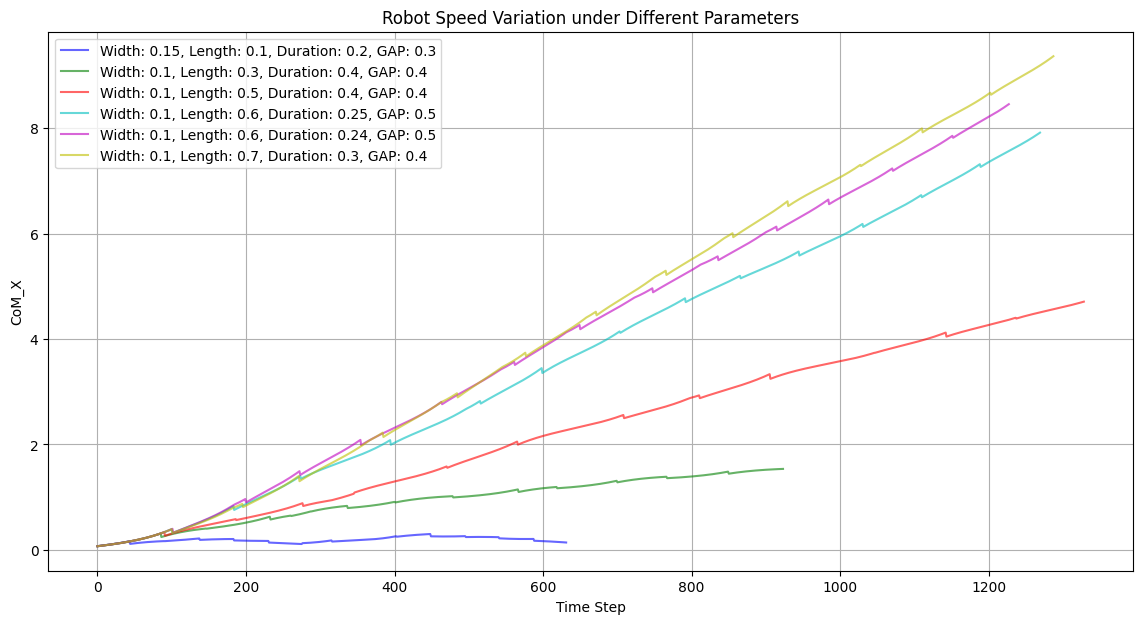

In [782]:
# 添加数据
DCMRealTrajectory_list.append(np.array(DCMRealTrajectory))
CoMTrajectory_list.append(np.array(CoMTrajectory))
CoPTrajectory_list.append(np.array(CoPTrajectory))
parameters_list.append(f"Width: {NominalStepWidth}, Length: {NominalStepLength}, Duration: {Ntime}, GAP: {GAP}")


# 颜色列表，用于区分不同曲线
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# 画 CoM_X 的图像，标题和图例进行了相应修改
figg, ax = plt.subplots(figsize=(14, 7))
for i in range(len(CoMTrajectory_list)):
    color = color_list[i % len(color_list)]  # 循环使用颜色列表
    ax.plot(np.array(CoMTrajectory_list[i])[:, 0], color=color, alpha=0.6, label=f"{parameters_list[i]}")
    
ax.legend()  # 显示图例
ax.set_title("Robot Speed Variation under Different Parameters")  # 设置标题
ax.set_xlabel("Time Step")  # 设置x轴标签
ax.set_ylabel("CoM_X")  # 设置y轴标签
ax.grid(True)  # 显示网格
plt.show()




# #FFFFFF 画图部分
# figg, (ax) = plt.subplots(figsize=(14, 7))
# ax.plot(np.array(DCMRealTrajectory)[:, 0], 'b', label="DCM_X")
# ax.plot(np.array(CoMTrajectory)[:, 0], 'g', label="CoM_X")
# ax.plot(np.array(CoPTrajectory)[:, 0], 'r', label="CoP_X")
# ax.legend()  # 添加这一行来显示图例
# plt.show() 

# figg1, (ax1) = plt.subplots(figsize=(14, 7))
# ax1.plot(np.array(DCMRealTrajectory)[:, 1], 'b', label="DCM_Y")
# ax1.plot(np.array(CoMTrajectory)[:, 1], 'g', label="CoM_Y")
# ax1.plot(np.array(CoPTrajectory)[:, 1], 'r', label="CoP_Y")
# ax1.legend()  # 添加这一行来显示图例
# plt.show() 

# figg2, (ax2) = plt.subplots(figsize=(14, 7))
# ax2.plot(np.array(DCMRealTrajectory)[:, 0], np.array(DCMRealTrajectory)[:, 1], 'b', label="DCM")
# ax2.plot(np.array(CoMTrajectory)[:, 0], np.array(CoMTrajectory)[:, 1], 'g', label="CoM")
# ax2.plot(np.array(CoPTrajectory)[:, 0], np.array(CoPTrajectory)[:, 1], '*r', label="CoP")
# ax2.legend()  # 添加这一行来显示图例
# plt.show() 

# # # 显示 dt*internalStep 和 stepDuration 的变化
# # figg, (ax) = plt.subplots(figsize=(14, 7))
# # ax.plot(np.array(stepDuration_list), 'b', label="stepDuration")
# # ax.plot(np.array(dt_list), 'r', label="dt*internalstep")
# # ax.legend()  # 添加这一行来显示图例
# # plt.show() 

In [781]:
# # 绘制函数

# # 添加数据
# # DCMRealTrajectory_list.append(np.array(DCMRealTrajectory))
# # CoMTrajectory_list.append(np.array(CoMTrajectory))
# # CoPTrajectory_list.append(np.array(CoPTrajectory))

# # 绘制函数
# def plot_data():
#     # 清除之前的图像
#     ax.clear()
#     ax1.clear()
#     ax2.clear()

#     # 重新绘制所有存储的数据
#     for i, (dcm, com, cop) in enumerate(zip(DCMRealTrajectory_list, CoMTrajectory_list, CoPTrajectory_list)):
#         ax.plot(dcm[:, 0], 'b', label=f"DCM_X_run{i + 1}")
#         ax.plot(com[:, 0], 'g', label=f"CoM_X_run{i + 1}")
#         ax.plot(cop[:, 0], 'r', label=f"CoP_X_run{i + 1}")

#         ax1.plot(dcm[:, 1], 'b', label=f"DCM_Y_run{i + 1}")
#         ax1.plot(com[:, 1], 'g', label=f"CoM_Y_run{i + 1}")
#         ax1.plot(cop[:, 1], 'r', label=f"CoP_Y_run{i + 1}")

#         ax2.plot(dcm[:, 0], dcm[:, 1], 'b', label=f"DCM_run{i + 1}")
#         ax2.plot(com[:, 0], com[:, 1], 'g', label=f"CoM_run{i + 1}")
#         ax2.plot(cop[:, 0], cop[:, 1], '*r', label=f"CoP_run{i + 1}")

#     # 显示图例
#     ax.legend()
#     ax1.legend()
#     ax2.legend()

#     # # 绘制更新后的图像
#     # figg.canvas.draw()
#     # figg1.canvas.draw()
#     # figg2.canvas.draw()

#     # 显示所有图
#     plt.show()

# # 添加数据的函数
# def add_data(DCMRealTrajectory, CoMTrajectory, CoPTrajectory):
#     # 将当前运行的数据添加到列表中
#     DCMRealTrajectory_list.append(np.array(DCMRealTrajectory))
#     CoMTrajectory_list.append(np.array(CoMTrajectory))
#     CoPTrajectory_list.append(np.array(CoPTrajectory))

#     # 调用 plot_data 进行叠加绘图
#     plot_data()

# # 示例调用
# add_data(DCMRealTrajectory, CoMTrajectory, CoPTrajectory)  # 第一次数据